In [ ]:
!pip install cartopy regionmask

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import regionmask

In [5]:
def F(x):
  return -2*x**3+x**2+2.1

x = np.arange(-5,5, 0.1)
y = F(x)

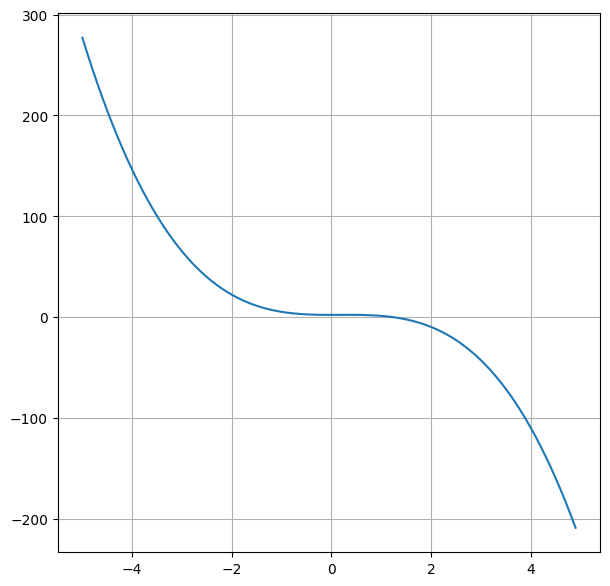

In [6]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x,y)
ax.grid(True)

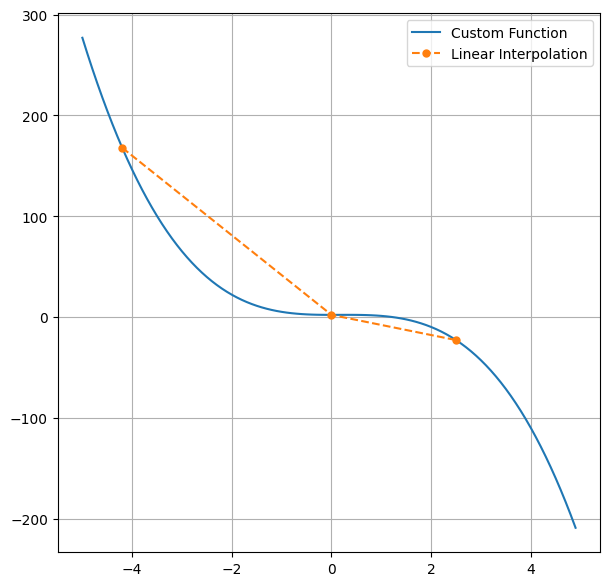

In [7]:
x_dots = np.array([-4.2, 0, 2.5])
y_dots = F(x_dots)
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x,y, label='Custom Function')
ax.plot(x_dots,y_dots, marker='o', markersize=5, ls='--', label='Linear Interpolation')
ax.grid(True)
plt.legend()
plt.show()

# Getting Weather Data

Original Data Source: https://www.ncdc.noaa.gov/cdo-web/datatools/selectlocation

Data Used in Tutorial: https://drive.google.com/drive/folders/1GZKWJx1xeJLWfm3wqQrUfSZ_7Qc6z31J?usp=sharing

In [6]:
df = pd.read_csv('/content/drive/My Drive/Medium/interpolation/3639866.csv')
df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG
0,SZE00105086,"SION 2, SZ",46.2167,7.3331,482.0,2024-03-21,53
1,SZ000002220,"SAENTIS, SZ",47.2500,9.3500,2502.0,2024-03-21,30
2,SZM00006796,"STATION MARIA VAL MUESTAIR, SZ",46.6000,10.4330,1390.0,2024-03-21,47
3,SZ000008440,"GENEVE COINTRIN, SZ",46.2500,6.1331,420.0,2024-03-21,59
4,SZ000003700,"ZUERICH FLUNTERN, SZ",47.3831,8.5667,555.0,2024-03-21,54
5,SZE00116090,"PAYERNE, SZ",46.8167,6.9500,490.0,2024-03-21,57
6,SZ000001940,"BASEL BINNINGEN, SZ",47.5331,7.5831,316.0,2024-03-21,58
7,SZ000009480,"LUGANO, SZ",46.0000,8.9667,273.0,2024-03-21,59


<Axes: >

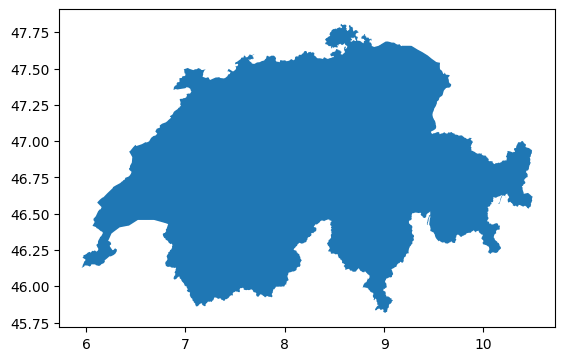

In [7]:
shape = gpd.read_file('/content/drive/My Drive/Medium/interpolation/shape/gadm41_CHE_0.shp')
shape.plot()

In [8]:
points = list()
for i in range(len(df)):
  point = Point(df.loc[i, 'LONGITUDE'], df.loc[i, 'LATITUDE'])
  points.append(point)

gdf = gpd.GeoDataFrame(geometry=points).set_crs(shape.crs)

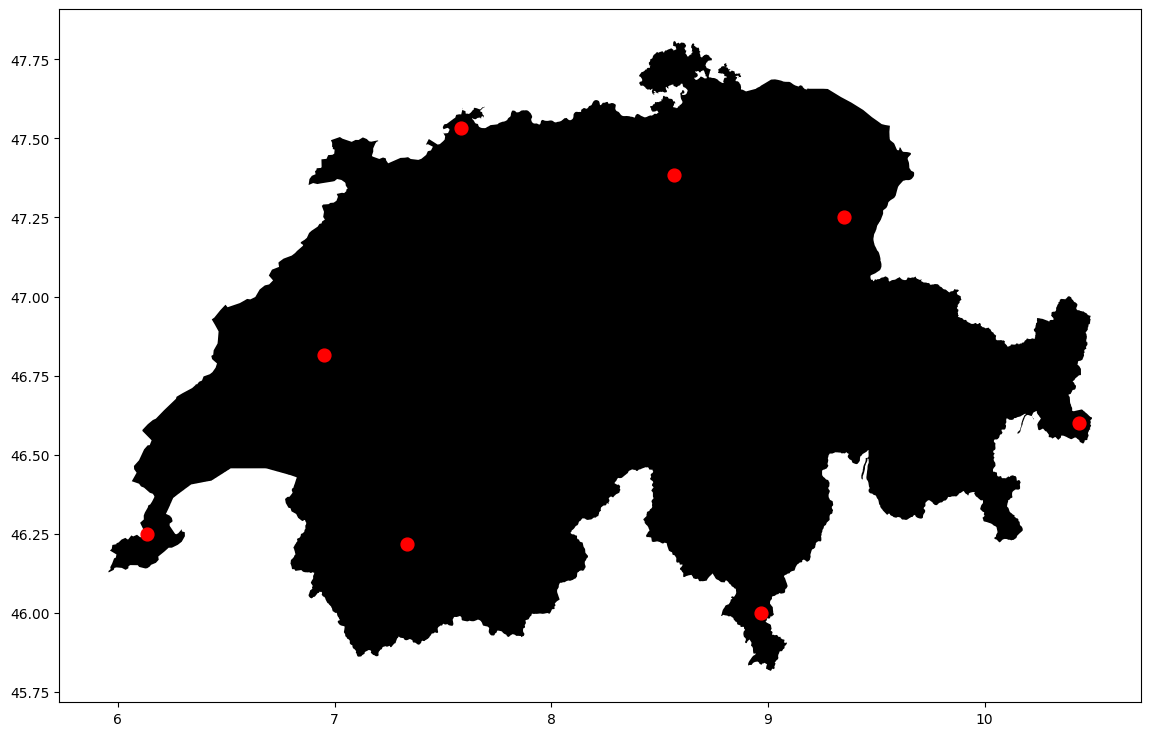

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
shape.plot(ax=ax, color='black')
gdf.plot(ax=ax, color='r', markersize=85)
plt.show()

In [10]:
LAT, LON = np.arange(45.75, 48, 0.1), np.arange(6, 10.81, 0.1)

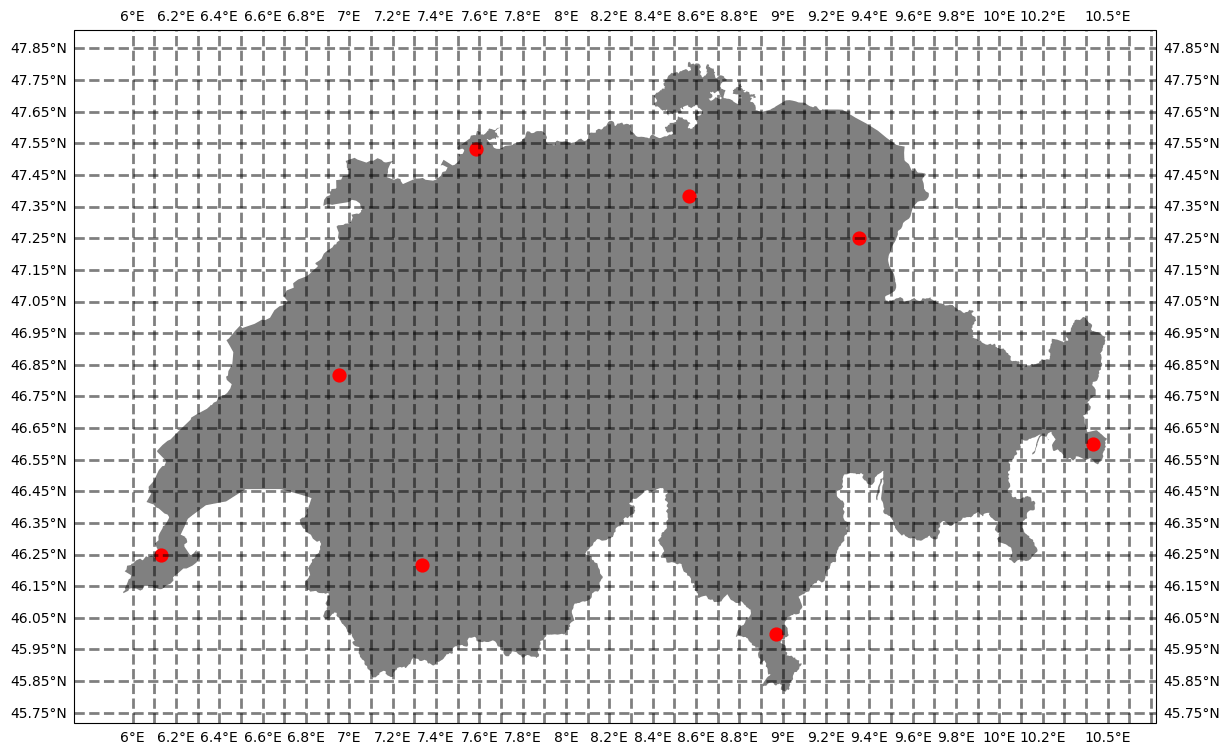

In [22]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16, 9))
shape.plot(ax=ax, color='grey')
gdf.plot(ax=ax, color='r', markersize=85)

gl = ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(LON)
gl.ylocator = mticker.FixedLocator(LAT)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.show()

# I. Nearest Neighbor (NN)

In [13]:
def Euclidean(x1,x2,y1,y2):
  return ((x1-x2)**2+(y1-y2)**2)**0.5

def NN(data, LAT, LON):
  array = np.empty((LAT.shape[0], LON.shape[0]))

  for i, lat in enumerate(LAT):
    for j, lon in enumerate(LON):
      idx = data.apply(lambda row: Euclidean(row.LONGITUDE, lon, row.LATITUDE, lat), axis = 1).argmin()
      array[i,j] = data.loc[idx, 'TAVG']
  return array

In [15]:
t2m = NN(df, LAT, LON)
t2m.shape

(23, 49)

In [16]:
ds = xr.Dataset(
    {'TAVG': (['lat', 'lon'], t2m)},
    coords={'lat': LAT, 'lon': LON})
ds

<xarray.Dataset>
Dimensions:  (lat: 23, lon: 49)
Coordinates:
  * lat      (lat) float64 45.75 45.85 45.95 46.05 ... 47.65 47.75 47.85 47.95
  * lon      (lon) float64 6.0 6.1 6.2 6.3 6.4 6.5 ... 10.4 10.5 10.6 10.7 10.8
Data variables:
    TAVG     (lat, lon) float64 59.0 59.0 59.0 59.0 59.0 ... 30.0 47.0 47.0 47.0

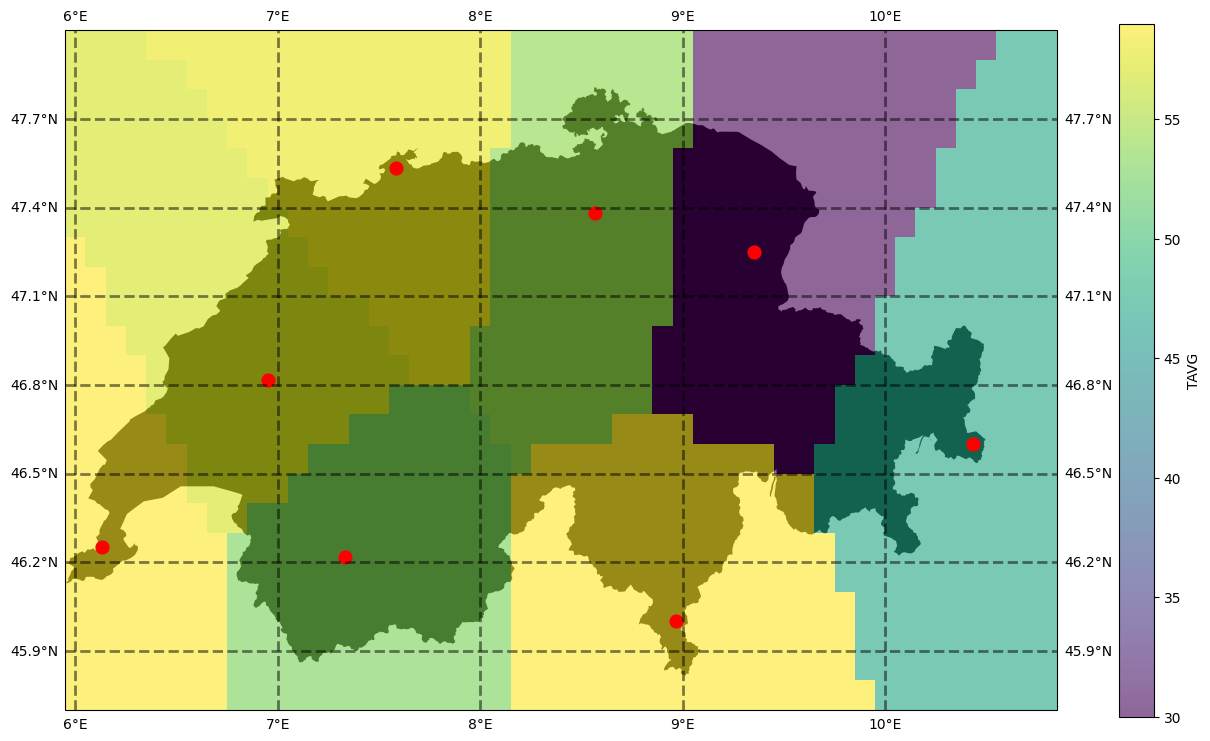

In [24]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16, 9))
shape.plot(ax=ax, color='black')
ds.TAVG.plot(ax=ax, alpha=0.6)
gdf.plot(ax=ax, color='r', markersize=85)
ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')


plt.show()

In [17]:
shape['new_column'] = 0
sw = shape.dissolve(by='new_column')['geometry']
rg = regionmask.mask_3D_geopandas(sw, lon_or_obj=ds.lon, lat=ds.lat)

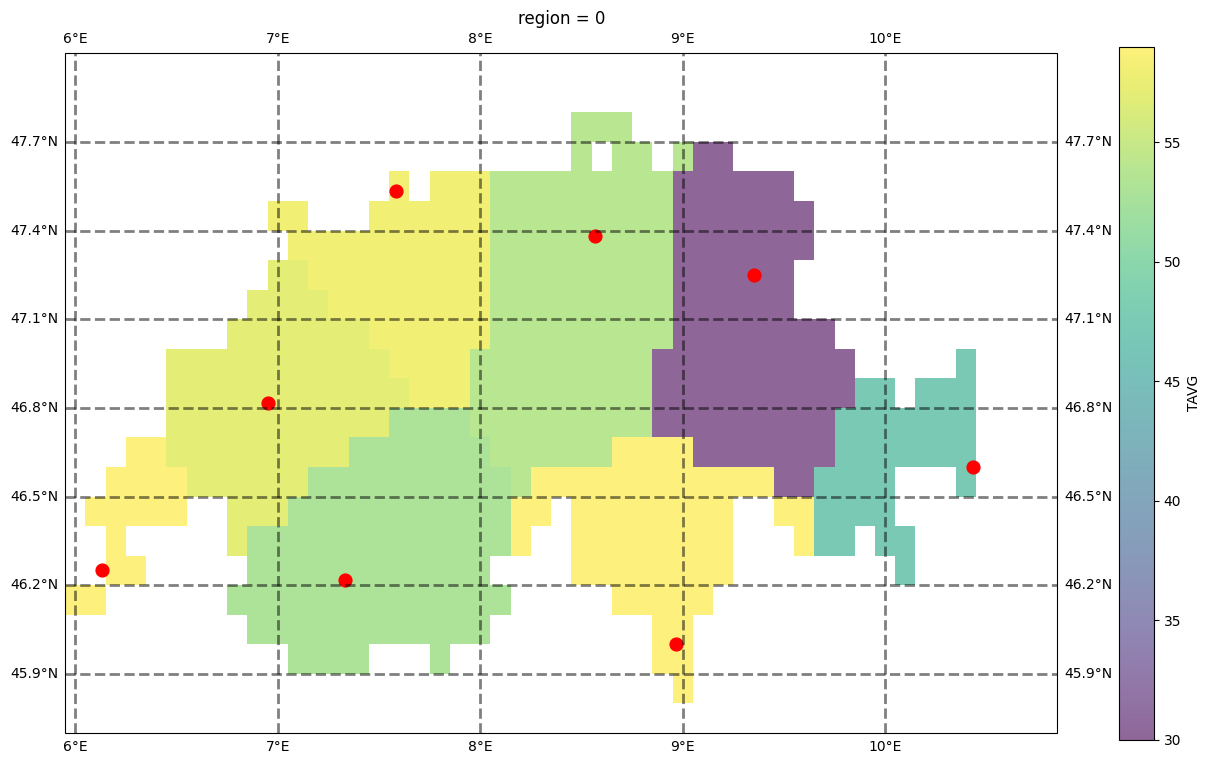

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16, 9))
#shape.plot(ax=ax, color='black')
ds.where(rg).TAVG.plot(ax=ax, alpha=0.6)
gdf.plot(ax=ax, color='r', markersize=85)
ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')
plt.show()

# II. Inverse Distance Weighting (IDW)

In [ ]:
def IDW(data, LAT, LON, betta=2):
  array = np.empty((LAT.shape[0], LON.shape[0]))

  for i, lat in enumerate(LAT):
    for j, lon in enumerate(LON):
      weights = data.apply(lambda row: Euclidean(row.LONGITUDE, lon, row.LATITUDE, lat)**(-betta), axis = 1)
      z = sum(weights*data.TAVG)/weights.sum()
      array[i,j] = z
  return array

In [ ]:
t2m = IDW(df, LAT, LON)
ds = xr.Dataset(
    {'TAVG': (['lat', 'lon'], t2m)},
    coords={'lat': LAT, 'lon': LON})

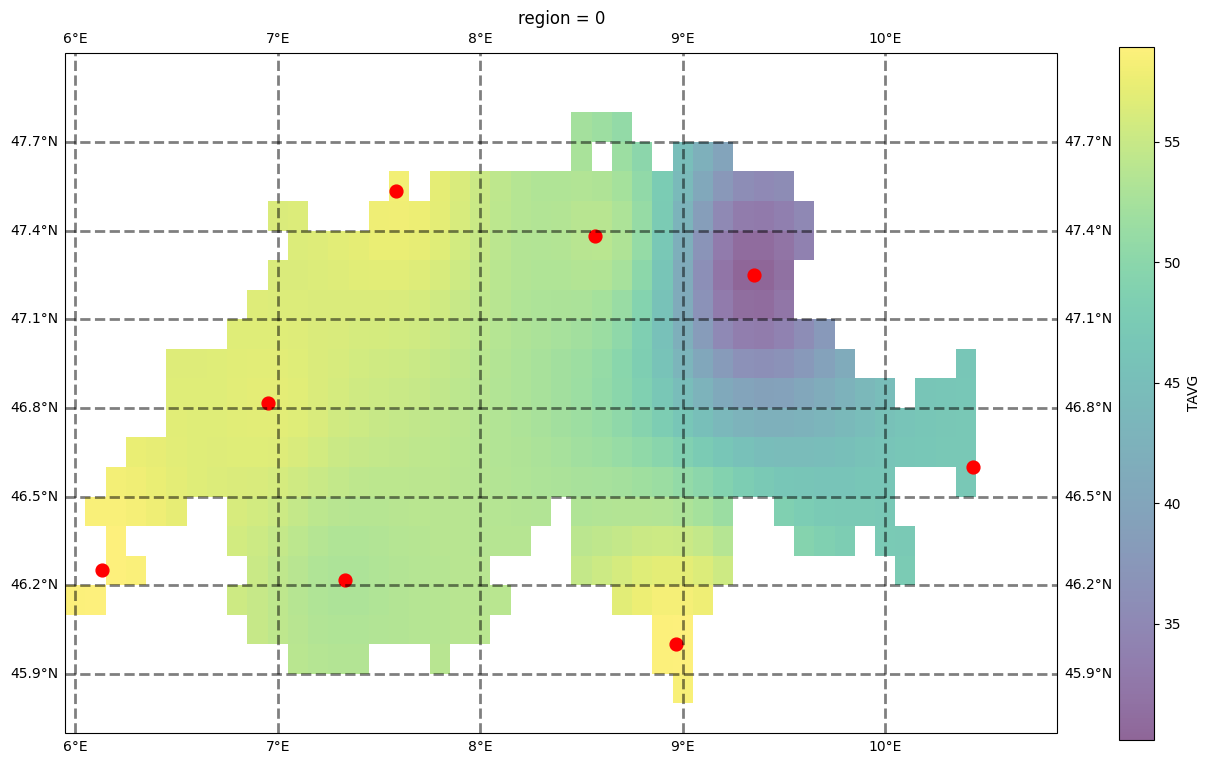

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16, 9))
#shape.plot(ax=ax, color='black')
ds.where(rg).TAVG.plot(ax=ax, alpha=0.6)
gdf.plot(ax=ax, color='r', markersize=85)
ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')
plt.show()

# IV. Kriging

> https://iri.columbia.edu/~rijaf/CDTUserGuide/html/interpolation_methods.html







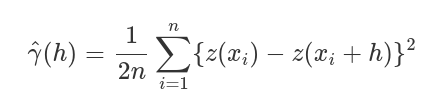

In [ ]:
from scipy.linalg import solve
from itertools import product
from sklearn.metrics import mean_squared_error as MSE

class OrdinaryKriging:
    def __init__(self, lats, lons, values):
        self.lats = lats
        self.lons= lons
        self.values = values
        self.nugget_values = [0, 1, 2, 3, 4]
        self.sill_values = [1, 2, 3, 4, 5]
        self.range_values = [1, 2, 3, 4, 5]

        # Generate all combinations of parameter values
        self.parameter_combinations = list(product(self.nugget_values, self.sill_values, self.range_values))
        self.optimal_pars = None

    def theoretical_variogram(self, h, nugget, sill, r):
        return nugget + (sill-nugget) * (1-np.exp(-3*h/r))

    def Euclidean(self, X, Y):
        all_dists, point_dists = [], []
        for x,y in zip(X, Y):
          k = 0
          for k in range(len(X)):
            h = np.linalg.norm(np.array([x, y]) - np.array([X[k], Y[k]]))
            point_dists.append(h)
          all_dists.append(point_dists)
          point_dists = []
        return all_dists

    def gamma(self):
        distances = self.Euclidean(self.lats, self.lons)
        differences = np.abs(self.values.reshape(-1,1) - self.values)
        variogram_values = []
        for h in np.unique(distances):
            values_at_h = differences[(distances == h)]
            variogram_values.append(np.mean(values_at_h**2))
        return variogram_values, np.unique(distances)

    def fit(self):
        experimental_variogram, distances = self.gamma()
        fit_metrics = []
        for nugget, sill, range_ in self.parameter_combinations:
            theoretical_variogram_values = self.theoretical_variogram(distances, nugget, sill, range_)
            fit_metric = MSE(experimental_variogram, theoretical_variogram_values)
            fit_metrics.append((nugget, sill, range_, fit_metric))

        self.optimal_pars = min(fit_metrics, key=lambda x: x[3])[:3]

    def predict(self, point):
        points = np.array([(x,y) for x,y in zip(self.lats, self.lons)])
        distances = np.linalg.norm(points - point, axis=1)
        pars = list(self.optimal_pars)
        pars.insert(0, distances)
        weights = self.theoretical_variogram(*pars)
        weights /= np.sum(weights)
        return np.dot(weights, self.values)

kriging = OrdinaryKriging(df.LATITUDE.values, df.LONGITUDE.values, df.TAVG.values)

kriging.fit()

row, grid = [], []
for lat in LAT:
  for lon in LON:
    row.append(kriging.predict(np.array([lat, lon])))
  grid.append(row)
  row=[]

ds = xr.Dataset(
    {'TAVG': (['lat', 'lon'], grid)},
    coords={'lat': LAT, 'lon': LON})

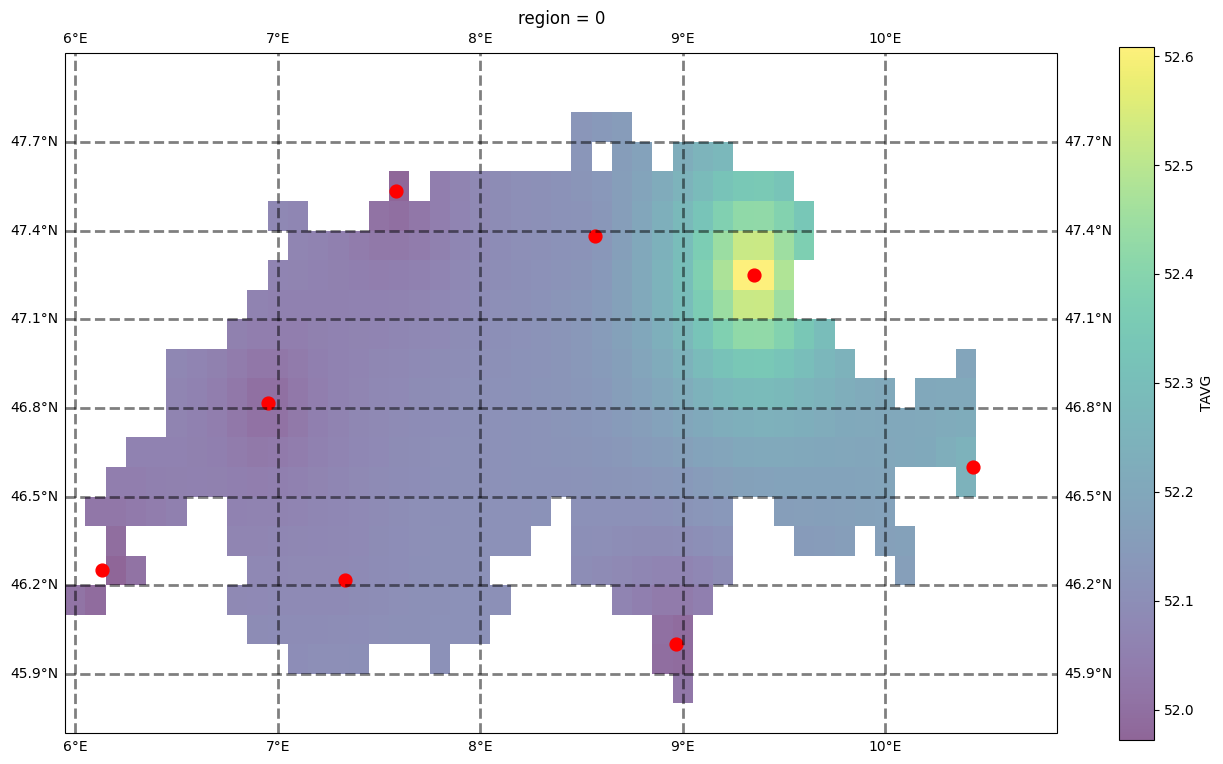

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(16, 9))
#shape.plot(ax=ax, color='black')
ds.where(rg).TAVG.plot(ax=ax, alpha=0.6)
gdf.plot(ax=ax, color='r', markersize=85)
ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')
plt.show()